In [223]:
from __future__ import print_function
import sys
import os
import logging
import six
from natsort import os_sorted
from radiomics import featureextractor, getFeatureClasses, firstorder, getTestCase, glcm, glrlm, glszm, imageoperations, shape
import radiomics
import numpy as np
import nrrd
import SimpleITK as sitk

import pandas as pd


import pydicom as pdm
import nilearn as nl
import nilearn.plotting as nlplt
from nilearn import plotting
import nrrd
import h5py

import matplotlib.pyplot as plt
from matplotlib import cm
import matplotlib.animation as anim

import imageio
from skimage.transform import resize
from skimage.util import montage

from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LassoCV
import warnings
warnings.simplefilter("ignore")

In [171]:
# Imagepath is the path where MRI patient images are stored
# maskPath is the path where corresponding tumor ROIs are stored
# clinicalpath is the file containing patient ID/gleason score/ucla (likert score)/PSA level/Tumor target index (ignore)

imagePath = "MR data"
maskPath = "Lesion data"
clinicalpath = "clinicaldata.csv"
# Read in patient ID/gleason score/ucla (likert score)/PSA level/Tumor target index (ignore)
df = pd.read_csv(clinicalpath, delimiter = ',')


# This method takes MRI image path and returns patient ID
def getidfrommr(path):

    return path.split('MR data/')[1].split('.nrrd')[0]

# This method takes segmentation data path and returns patient ID
def getidfromsg(path):
    return path.split('seriesUID-')[1].split('.nrrd')[0]

# This method takes patient ID and returns ucla Likert score
def getgleasonfromid(id):
   num = df.loc[df['ids'] == id]['gleason'].values.astype(int)
   return num
# This method takes patient ID and returns UCLA Likert score
def getuclafromid(id):
   num = df.loc[df['ids'] == id]['ucla'].values.astype(int)
   return num
# This method takes patient ID and returns PSA levels.
def getpsafromid(id):
   num = df.loc[df['ids'] == id]['PSA'].values
   return num

# This method takes patient ID and returns tumor ROI path
def gettargetnum(id):

    return df.loc[df['ids'] == id]['target'].astype(int)

In [178]:
# Now you need to start organizing the data. You can use os.walk() to find the MRI files and tumor ROI files,
# However, for each patient, you will use the patient ID ( can be found in both excel file and MRI filename and tumor ROI target name)
# And match each MRI file to the correct tumor ROI file.
# You can use any of the previous method to do this.


# This stores the MRI file path
each_MR_path = []
for path, directories, files in os.walk(imagePath):
    all_files = files
    break
for file in all_files:
    if file[0] != ".":
        each_MR_path.append(os.path.join(imagePath, file))

# This stores the tumor ROI file path
each_stl_path = []
for path, directories, files in os.walk(maskPath):
    all_files = files
    break
for file in all_files:
    each_stl_path.append(os.path.join(maskPath, file))

# This stores the patient ID
patient_idx = []
for path in each_stl_path:
    patient_idx.append(getidfromsg(path))




In [392]:
# Now you can perform feature extraction.
# Make sure each patient id in each_MR_path matches the one in each_stl_path before you perform this step!!!

# datapyr is the pyradiomics folder. You need to locate this on your PC!
datapyr = '/Users/shuang/pyradiomics'

# params is the file path for the feature extraction template. Please go to this folder and select the corresponding template
# You can choose between exampleMR_3mm.yaml and exampleMR_5mm.yaml
params = os.path.join(datapyr,  'examples', 'exampleSettings', 'exampleMR_3mm.yaml')

# This instantiates the extractor based on your selected template
extractor = featureextractor.RadiomicsFeatureExtractor(params)

# This will print out all the enabled filters and features.
print('Extraction parameters:\n\t', extractor.settings)
print('Enabled filters:\n\t', extractor.enabledImagetypes)
print('Enabled features:\n\t', extractor.enabledFeatures)
print()

# Create dictionary to store features from each group of tumor grade
features= {}
benign_features = {}
low_grade_features = {}
med_grade_features = {}
high_grade_features = {}
data = []
target = []

# for loop run through each patient to extract features.
# First, load in the MRI file using sitk.ReadImage. Then load the corresponding mask.
# Then set the mask direction and origin to that of the MR image.
# For each patient, we get the id and use that to get the gleason score/PSA/UCLA Likert score
# Then we classify the patient into corresponding tumor grade.
# Then we extract and store the features as well as PSA and Likert scores in the dictionary.

for i in range(0, len(each_MR_path)):

    try:

        image = sitk.ReadImage(each_MR_path[i])
        mask = sitk.ReadImage(each_stl_path[i])
        mask.SetDirection(image.GetDirection())
        mask.SetOrigin(image.GetOrigin())
        
        id = getidfrommr(each_MR_path[i])
        gleason = getgleasonfromid(id)
        ucla = getuclafromid(id)
        psa = getpsafromid(id)
        
        if (gleason == 0).all():
            benign_features[id] = extractor.execute(image, mask)
            target.append(gleason)
            data.append(list(benign_features[id].items()))
            benign_features[id]['ucla'] = ucla
            benign_features[id]['PSA'] = psa
        elif (gleason  == 6).all():
            low_grade_features[id] = extractor.execute(image, mask)
            target.append(gleason)
            data.append(list(low_grade_features[id].items()))
            low_grade_features[id]['ucla'] = ucla
            low_grade_features[id]['PSA'] = psa
        elif (gleason == 7).all():
            med_grade_features[id] = extractor.execute(image, mask)
            target.append(gleason)
            data.append(list(med_grade_features[id].items()))
            med_grade_features[id]['ucla'] = ucla
            med_grade_features[id]['PSA'] = psa
        elif (gleason ==  8).all():
            high_grade_features[id] = extractor.execute(image, mask)
            target.append(gleason)
            data.append(list(high_grade_features[id].items()))
            high_grade_features[id]['ucla'] = ucla
            high_grade_features[id]['PSA'] = psa
        print('Done', i)

    except ValueError as e:
        if len(e.args) > 0 and 'Size of the ROI is too small' in e.args[0]:
            pass
        else:
            print(e.args[0])
#             raise e

features['Benign features'] = benign_features
features['Low risk features'] = low_grade_features
features['Med risk features'] = med_grade_features
features['High risk features'] = high_grade_features

Extraction parameters:
	 {'minimumROIDimensions': 2, 'minimumROISize': None, 'normalize': True, 'normalizeScale': 100, 'removeOutliers': None, 'resampledPixelSpacing': [2, 2, 2], 'interpolator': 'sitkBSpline', 'preCrop': False, 'padDistance': 5, 'distances': [1], 'force2D': False, 'force2Ddimension': 0, 'resegmentRange': None, 'label': 1, 'additionalInfo': True, 'binWidth': 5, 'voxelArrayShift': 300}
Enabled filters:
	 {'Original': {}, 'LoG': {'sigma': [2.0, 3.0, 4.0, 5.0]}, 'Wavelet': {}}
Enabled features:
	 {'shape': None, 'firstorder': None, 'glcm': ['Autocorrelation', 'JointAverage', 'ClusterProminence', 'ClusterShade', 'ClusterTendency', 'Contrast', 'Correlation', 'DifferenceAverage', 'DifferenceEntropy', 'DifferenceVariance', 'JointEnergy', 'JointEntropy', 'Imc1', 'Imc2', 'Idm', 'Idmn', 'Id', 'Idn', 'InverseVariance', 'MaximumProbability', 'SumEntropy', 'SumSquares'], 'glrlm': None, 'glszm': None, 'gldm': None}

Done 0
mask only contains 1 segmented voxel! Cannot extract features

In [382]:
# Make sure you save the features into either pickle file or csv file
import pickle
feature_filename = "features_file"

with open(feature_filename,'wb') as pickle_file:
    pickle.dump(features, pickle_file)

Q1: Read in and visualize an MRI image (Not lesion ROI!) from one benign tumor, and one malignant tumor (GS >= 6)
Ans: The following two pictures are from 3D slicer, one is benign with 0 Gleason score and the other is maligant with 8 Gleason score.

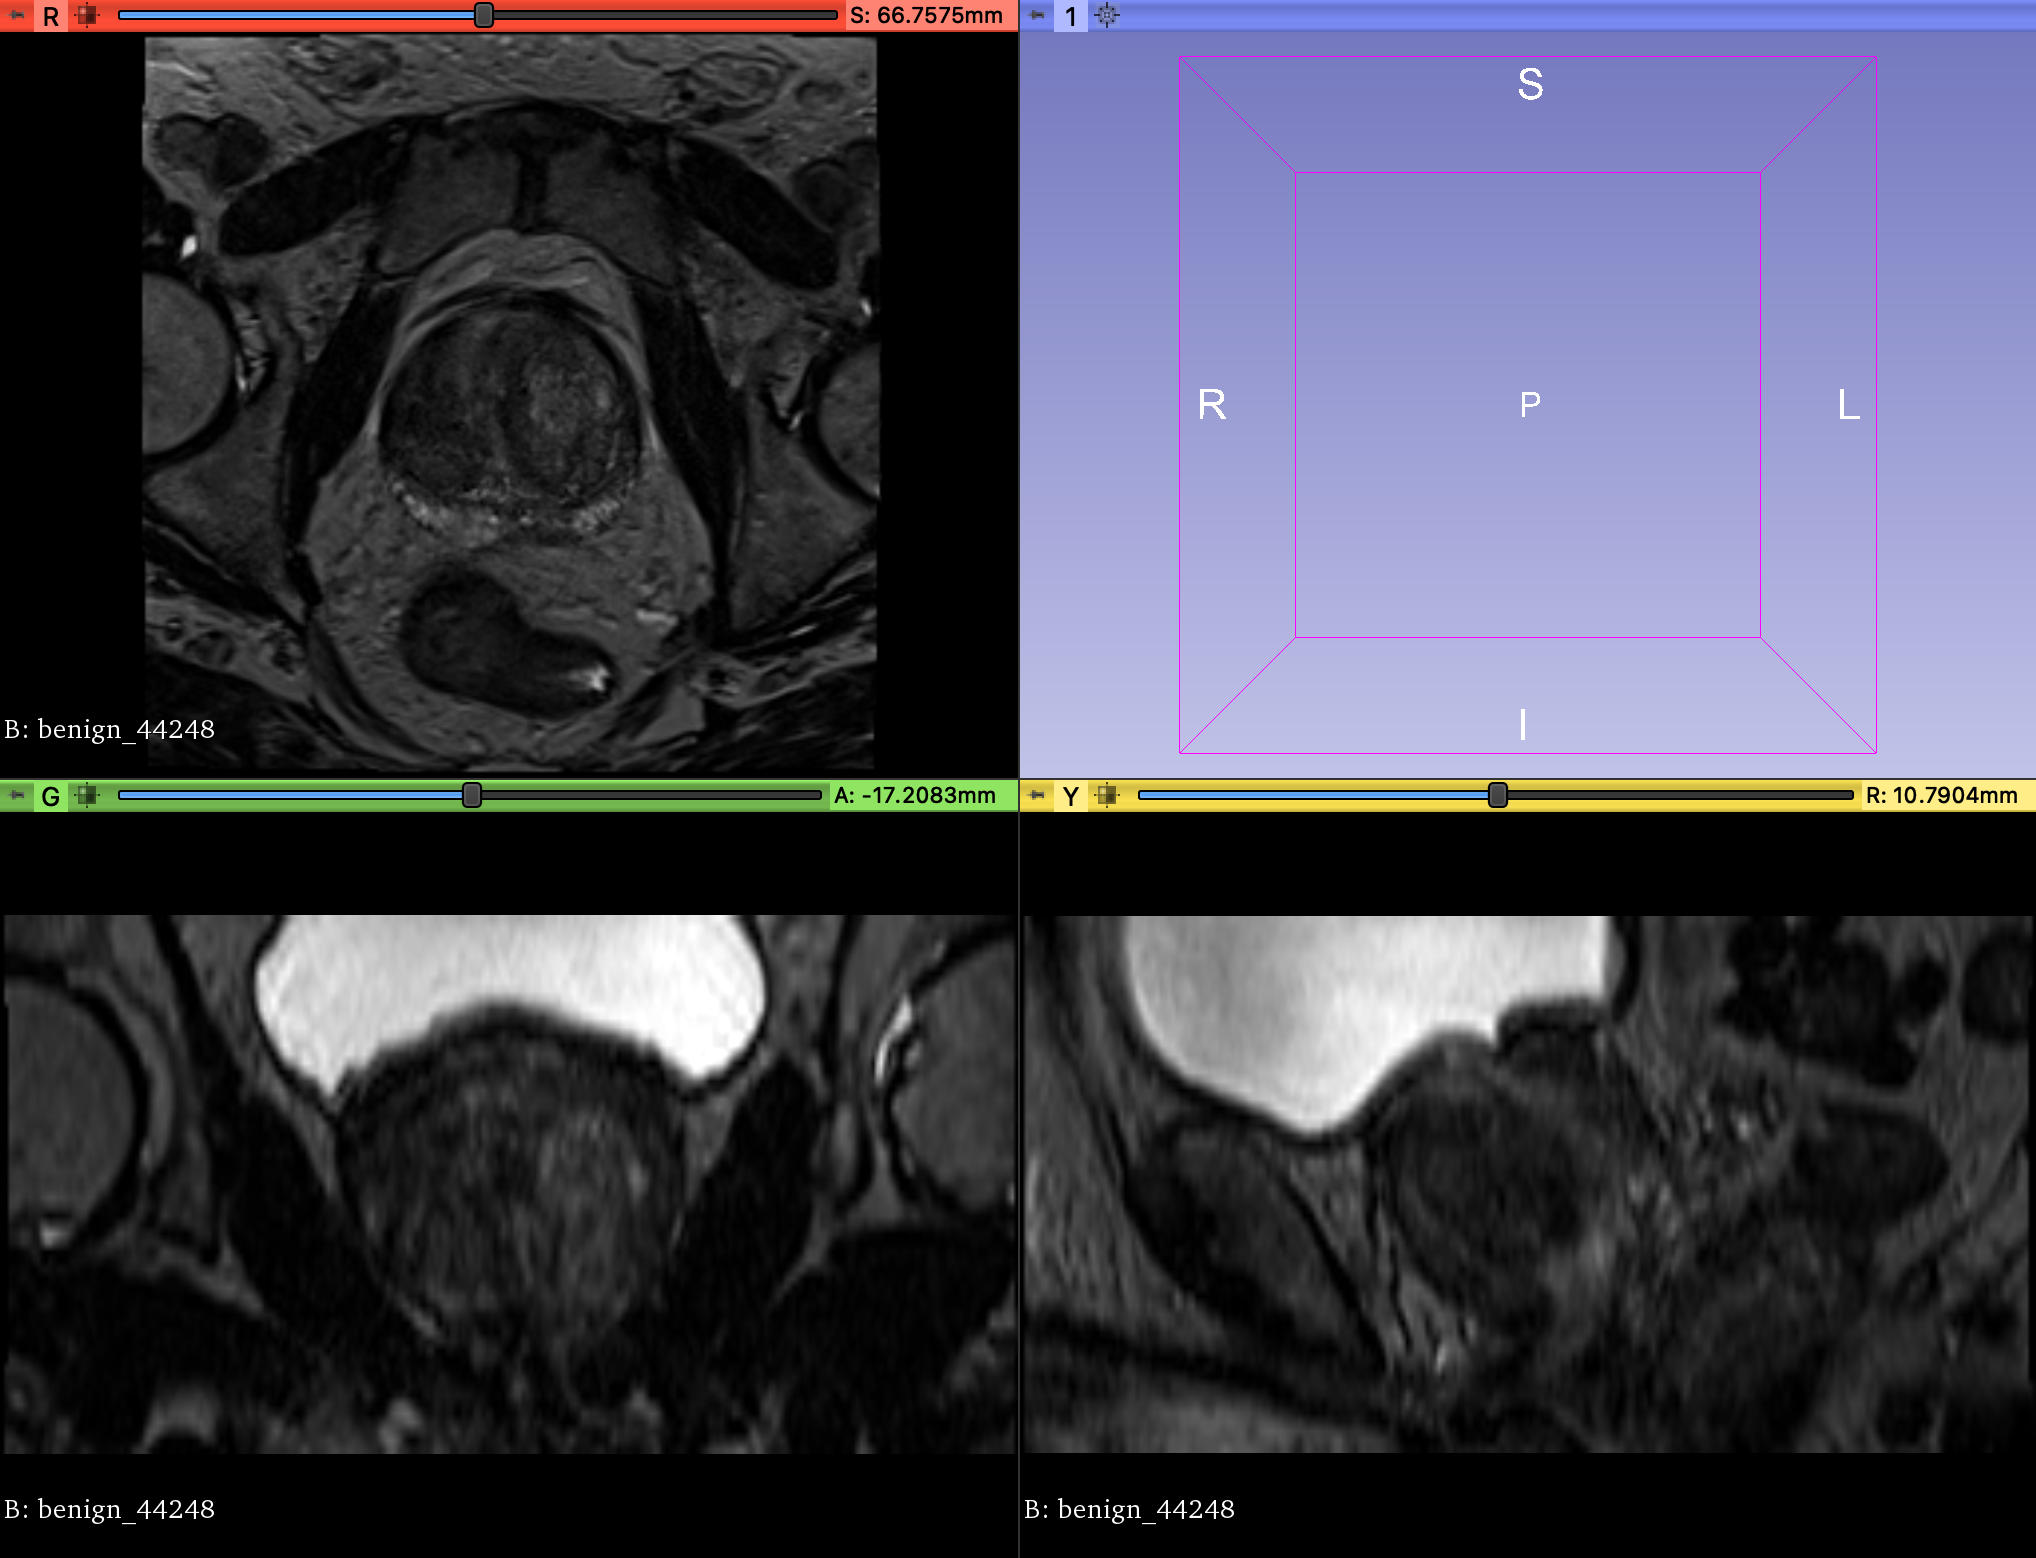

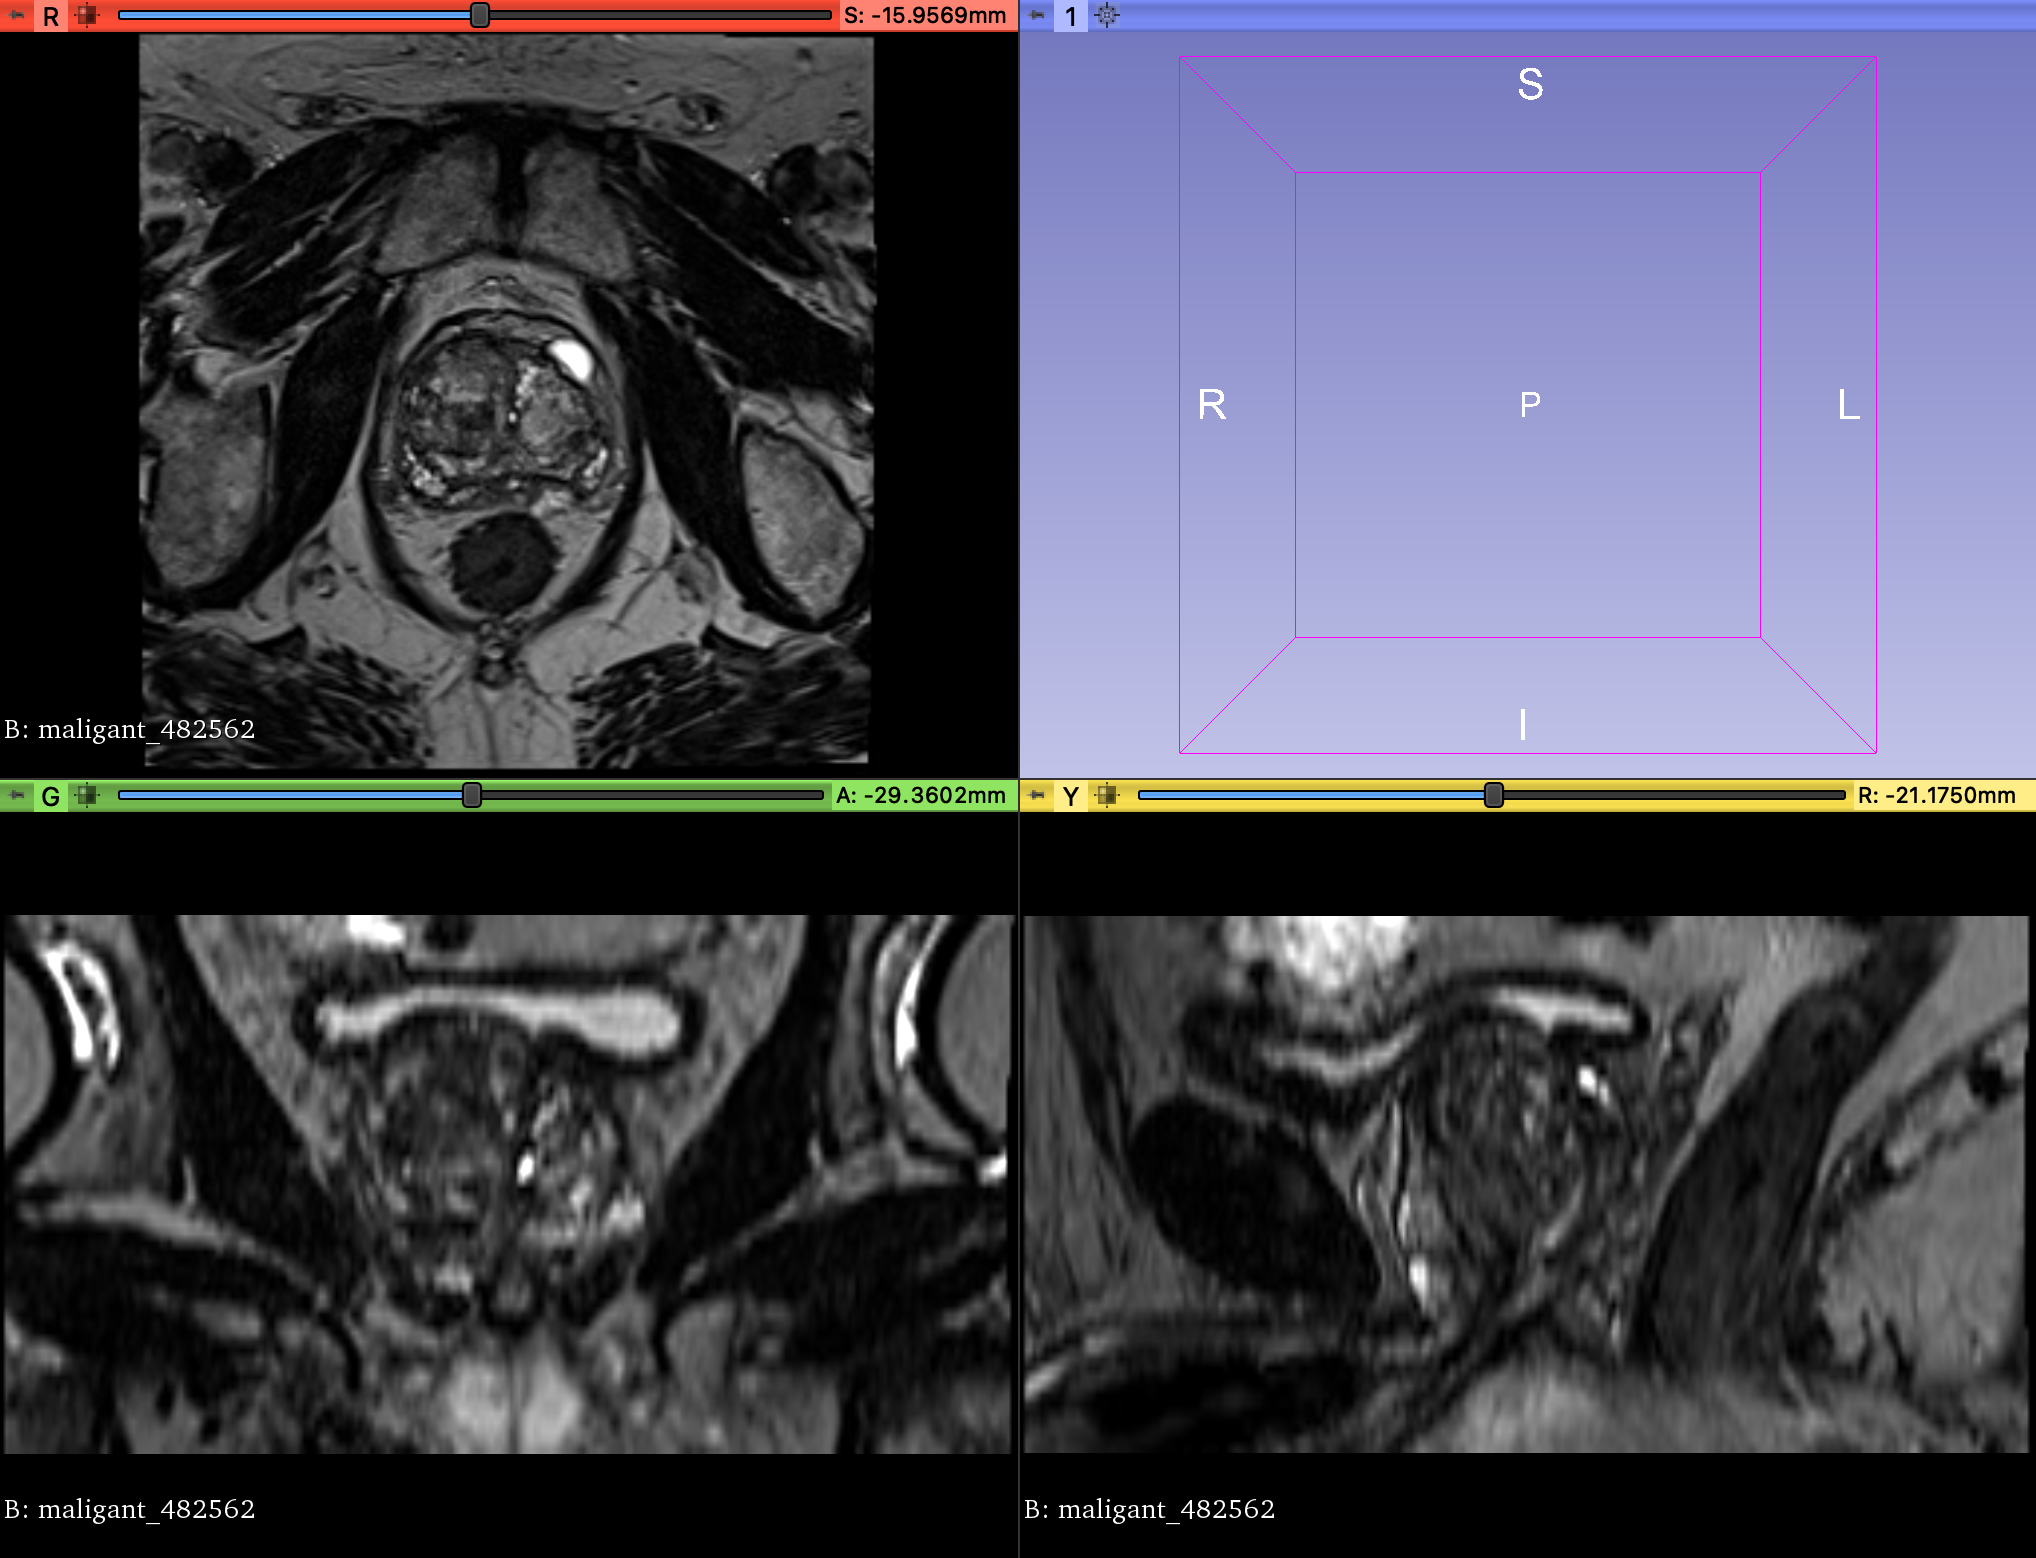

Q2: Formulate your own research question
Ans: Can we implement machine learning classifiers to distinguish prostate tumor grades based on prostate MRI radiomics features?

Q3: Perform feature selection using any of the following method using Sklearn: LASSO

In [686]:
from sklearn.preprocessing import StandardScaler
new_data = []
for data1 in data:
    temp = []
    feature_name = []
    for data2 in data1:
        temp.append(data2[1])
        feature_name.append(data2[0])
    new_data.append(temp[41:])

# patient 71's feature contains NaN, so we remove it from data
new_data = new_data[:71] + new_data[72:]
new_target = target[:71] + target[72:]
feature_name = feature_name[41:]
alphas = np.logspace(1,3,100)
model_lasso = LassoCV(alphas = alphas, cv=5,max_iter=1000).fit(new_data, new_target)
coef = pd.Series(model_lasso.coef_, index = feature_name)
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " + str(sum(coef == 0)))

Lasso picked 60 variables and eliminated the other 1068


In [687]:
print(model_lasso.alpha_)

162.97508346206433


In [688]:
coef[coef != 0]

original_firstorder_Energy                                       1.000805e-08
original_firstorder_TotalEnergy                                 -1.273221e-10
original_glcm_ClusterProminence                                  1.857878e-07
original_glcm_ClusterShade                                      -5.665782e-05
original_gldm_LargeDependenceHighGrayLevelEmphasis              -3.483621e-04
log-sigma-2-0-mm-3D_firstorder_Energy                            3.324079e-08
log-sigma-2-0-mm-3D_firstorder_TotalEnergy                      -1.814174e-10
log-sigma-2-0-mm-3D_glcm_ClusterProminence                      -8.215874e-09
log-sigma-3-0-mm-3D_firstorder_Energy                           -7.010609e-09
log-sigma-3-0-mm-3D_firstorder_TotalEnergy                      -1.496610e-10
log-sigma-3-0-mm-3D_glcm_ClusterProminence                      -1.281039e-05
log-sigma-3-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis        -4.386169e-05
log-sigma-4-0-mm-3D_firstorder_Energy                           

Q4: Visualize selected features in any feature space

In [689]:
import seaborn as sns
temp = [[0 for _ in range(sum(coef != 0))] for _ in range(175)]
for i in range(175):
    for j in range(sum(coef != 0)):
        temp[i][j] = float(new_data[i][j])
selected_feature = coef[coef != 0]
df = pd.DataFrame(temp, columns=list(selected_feature.index))
corr = df.corr(method='pearson', min_periods=1)
corr.style.background_gradient()

,original_firstorder_Energy,original_firstorder_TotalEnergy,original_glcm_ClusterProminence,original_glcm_ClusterShade,original_gldm_LargeDependenceHighGrayLevelEmphasis,log-sigma-2-0-mm-3D_firstorder_Energy,log-sigma-2-0-mm-3D_firstorder_TotalEnergy,log-sigma-2-0-mm-3D_glcm_ClusterProminence,log-sigma-3-0-mm-3D_firstorder_Energy,log-sigma-3-0-mm-3D_firstorder_TotalEnergy,log-sigma-3-0-mm-3D_glcm_ClusterProminence,log-sigma-3-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis,log-sigma-4-0-mm-3D_firstorder_Energy,log-sigma-4-0-mm-3D_firstorder_TotalEnergy,log-sigma-4-0-mm-3D_glcm_ClusterProminence,log-sigma-4-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis,log-sigma-5-0-mm-3D_firstorder_Energy,log-sigma-5-0-mm-3D_firstorder_TotalEnergy,log-sigma-5-0-mm-3D_glcm_ClusterProminence,log-sigma-5-0-mm-3D_glszm_LargeAreaHighGrayLevelEmphasis,log-sigma-5-0-mm-3D_gldm_LargeDependenceHighGrayLevelEmphasis,wavelet-LLH_firstorder_Energy,wavelet-LLH_firstorder_TotalEnergy,wavelet-LLH_firstorder_Variance,wavelet-LLH_glcm_ClusterProminence,wavelet-LLH_glcm_ClusterShade,wavelet-LHL_firstorder_Energy,wavelet-LHL_firstorder_TotalEnergy,wavelet-LHL_firstorder_Variance,wavelet-LHL_glcm_ClusterProminence,wavelet-LHL_glcm_ClusterShade,wavelet-LHL_glszm_LargeAreaHighGrayLevelEmphasis,wavelet-LHH_firstorder_Energy,wavelet-LHH_firstorder_TotalEnergy,wavelet-LHH_glcm_ClusterProminence,wavelet-HLL_firstorder_Energy,wavelet-HLL_firstorder_TotalEnergy,wavelet-HLL_firstorder_Variance,wavelet-HLL_glcm_ClusterProminence,wavelet-HLL_glcm_ClusterShade,wavelet-HLL_gldm_LargeDependenceHighGrayLevelEmphasis,wavelet-HLH_firstorder_Energy,wavelet-HLH_firstorder_TotalEnergy,wavelet-HLH_glcm_ClusterProminence,wavelet-HHL_firstorder_Energy,wavelet-HHL_firstorder_TotalEnergy,wavelet-HHL_firstorder_Variance,wavelet-HHL_glcm_ClusterProminence,wavelet-HHL_glszm_LargeAreaHighGrayLevelEmphasis,wavelet-HHL_gldm_LargeDependenceHighGrayLevelEmphasis,wavelet-HHH_firstorder_Energy,wavelet-HHH_firstorder_TotalEnergy,wavelet-HHH_glcm_ClusterProminence,wavelet-HHH_glszm_LargeAreaHighGrayLevelEmphasis,wavelet-LLL_firstorder_Energy,wavelet-LLL_firstorder_TotalEnergy,wavelet-LLL_firstorder_Variance,wavelet-LLL_glcm_ClusterProminence,wavelet-LLL_glcm_ClusterShade,wavelet-LLL_gldm_LargeDependenceHighGrayLevelEmphasis
original_firstorder_Energy,1.000000,0.935524,0.928737,0.970563,0.821279,0.951425,-0.603263,0.911209,-0.639578,0.823117,-0.142592,0.347616,0.759780,0.662416,0.278485,0.250532,0.566026,0.358899,0.117252,0.026069,-0.271336,0.605720,0.340546,0.162401,0.255092,0.759750,-0.453326,0.385092,0.424196,0.360481,0.391597,0.422195,0.507652,0.029176,0.640948,-0.011797,0.636102,0.299098,-0.458874,0.808261,0.761704,0.016479,0.046625,0.562388,0.049688,0.650308,0.048720,-0.478676,0.725406,0.394081,0.844300,-0.457882,0.383633,0.367008,0.253727,0.396085,-0.417341,-0.457708,0.685386,0.826240
original_firstorder_TotalEnergy,0.935524,1.000000,0.904230,0.953618,0.810580,0.967442,-0.551876,0.908244,-0.666848,0.812486,-0.160618,0.317738,0.733299,0.671312,0.262950,0.286244,0.574779,0.338490,0.099235,0.018715,-0.310094,0.625321,0.313380,0.142080,0.266074,0.733325,-0.462436,0.349887,0.419979,0.377093,0.346360,0.376897,0.464115,0.023850,0.619723,0.000287,0.652801,0.281788,-0.465522,0.827259,0.783434,0.018426,0.008851,0.559158,0.014161,0.650369,0.014559,-0.487578,0.736504,0.359307,0.848782,-0.467088,0.348863,0.360849,0.232135,0.388693,-0.445332,-0.483892,0.693860,0.816293
original_glcm_ClusterProminence,0.928737,0.904230,1.000000,0.967668,0.698244,0.926087,-0.640461,0.825333,-0.692389,0.700568,-0.168001,0.357005,0.625257,0.722479,0.328626,0.221120,0.587464,0.387873,0.119464,0.029755,-0.296065,0.632941,0.378836,0.166692,0.282035,0.625224,-0.506828,0.399980,0.437439,0.382712,0.386137,0.407139,0.518206,0.060156,0.688483,0.017750,0.706798,0.356073,-0.522317,0.861760,0.788419,0.082206,0.033049,0.595851,0.034060,0.681408,0.035580,-0.542645,0.789832,0.412776,0.733992,-0.512045,0.399082,0.386531,0.255149,0.412718,-0.45813

Q5: Perform classification using any of the following ML methods: Random forest, support vector machine, logistic regression

In [733]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
clf = RandomForestClassifier(max_depth=2, random_state=0)
X_train, X_test, y_train, y_test = train_test_split(new_data, new_target, test_size=0.3)
clf.fit(X_train, y_train)
print("The score of random forest method is: " + str(clf.score(X_test, y_test)))

The score of random forest method is: 0.33962264150943394


In [604]:
for i in range(len(y_test)):
    y_test[i] = int(y_test[i])
print(clf.predict(X_test))
print(y_test)

[7 8 7 6 7 8 6 6 8 7 7 6 7 6 6 7 8 8 7 6 8 7 7 7 7 0 7 7 8 7 8 6 7 8 7 7 0
 7 6 6 6 7 7 6 7 8 8 7 8 7 7 7 6]
[8, 0, 8, 8, 6, 8, 0, 6, 0, 0, 8, 7, 0, 6, 8, 6, 0, 7, 0, 6, 0, 6, 7, 6, 0, 6, 0, 8, 7, 7, 0, 0, 6, 7, 0, 6, 6, 8, 6, 6, 7, 6, 0, 0, 7, 6, 6, 8, 8, 8, 8, 7, 0]


Q6: Analyze and explain the performance of your model

Ans: We can see that my model has a below-average performance, the score(mean accuracy on the given test data and labels) of prediction result is 0.33962264150943394, I think the following resons may lead to this consequence:
1. The dataset is too small, which didn't provide suffient training.
2. The selected features are not proper or the seleced number is too large(233), maybe remove more features will give a better result. 
3. Maybe is data used in this mission is unbalanced.

Q7: Provide a brief explanation to your research question based on your findings
We can implement machine learning classifiers to distinguish prostate tumor grades based on prostate MRI radiomics features, however, the results are not ideal. Current obtained accuracy cannot be used in the medical scenerio. Since it is a simple model and doesn't take much time to train, it still has huge space to improve. On the other hand, trainning for trmendous batches on small dataset may cause the problem of overfit. Last but not least, predicting the accurate scores for patients may not give us a good result, while classifying them into different grades has potential development.